# Introduction to Computational General Equilibrium (CGE) Models

In this notebook we'll cover some basic ideas that will introduce you to CGE modelling, i.e., of solving Walrasian GE models in a computer. To make things simple we will focus on the easiest CGE model possible: a pure endowment economy with $M$ individuals and $N$ commodities. When $M=2$ and $N=2$, this is an economy that can be represented in an Edgeworth box.

# Preferences

We will focus on an economy in which all individuals have Cobb-Douglas preferences, i.e., we'll assume that each individual $i$ has utility

$$
u_i(x_{i1}, x_{i2}, \dots, x_{iN})= x_{i1}^{\alpha_{i1}} x_{i2}^{\alpha_{i2}} \cdots x_{iN}^{\alpha_{iN}}
$$

where $x_{ij}$ denoted the amount of good $j=1,\ldots,M$ she consumes. We assume that $\alpha_{ij}\ge0$ for all $j=1,2,\ldots,M$, $\sum_{j=1}^M\alpha_{ij}\le1$ to ensure the utility function is strictly quasi-concave. Let's denote the consumption plan of individual $i$ by $x_i\equiv(x_{i1}, x_{i2}, \ldots, x_{iM})$. 

Given a price vector $p=(p_1, p_2, \ldots,p_M)$, the value of her total expenditures is
$$
p\cdot x_i = \sum_{j=1}^M p_i\cdot x_{ij}.
$$

# Endowments

Each individual in the economy is endowed with a quantity of each good $\omega_{ij}\ge0$. We will denote by $\omega_i=(\omega_{i1}, \omega_{i2}, \ldots, \omega_{iM})$ the vector of endowments of an individual $i$.

Given her endowments vector and a price vector $p=(p_1, p_2, \ldots,p_M)$, the value of her resources is
$$
y_i \equiv p\cdot \omega_i = \sum_{j=1}^M p_i\cdot\omega_{ij}.
$$

# Individual's Optimal Consumption/Demand

Given her initial endowments $\omega_i$ and a price vector $p$, each individual $i$ choses her consumption basket $x^*_i$, which solves the following optimization problem

$$
\max_{x_i} u_i(x_{i1}, x_{i2}, \dots, x_{iN})= x_{i1}^{\alpha_{i1}} x_{i2}^{\alpha_{i2}} \cdots x_{iN}^{\alpha_{iN}}
$$

subject to

$$
p\cdot x_i\le y_i.
$$

Since the utility function is strictly quasiconcave and the restriction is convex, we can apply the [Kuhn-Tucker](https://econgrowth.github.io/notebooks/papers/kuhntucker1950.pdf) or [Arrow-Enthoven](http://www.jstor.org/stable/1911819) Theorems to find the optimal choices of the individual. But, since her utility is strictly increasing in all goods, we know the restriction will hold with equality and we can just use Langrange's method (if you need to review this material, check out [La Fuente Ch.7](https://www.amazon.com/Mathematical-Methods-Models-Economists-Fuente/dp/0521585295) or [Simon and Blume Ch.18](https://www.amazon.com/Mathematics-Economists-Carl-P-Simon/dp/0393957330)). The Langrangian is 

$$
\mathcal{L}(x_i, \lambda) = u_i(x_i)-\lambda(p\cdot x_i-y_i)
$$

so, her optimal consumption choice $x^*_i$ must satisfy

$$
\frac{\partial u_i(x^*_i)}{\partial x_{ij}}=\lambda p_j, \quad j=1,\ldots,M
$$

and the budget constraint. Given our assumption about the functional form of $u_i(x_i)$, this implies it must satisfy

$$
\frac{\alpha_{ij}}{x^*_{ij}}u_i(x^*_i)=\lambda p_j, \quad j=1,\ldots,M,
$$

which implies that for any two goods $j,j'=1,\ldots,M$

$$
\frac{\alpha_{ij}}{p_j \cdot x^*_{ij}}=\frac{\alpha_{ij'}}{p_{j'} \cdot x^*_{ij'}}.
$$

Replacing in the budget contraint we have

$$
p\cdot x_i = \sum_{j=1}^M p_j \cdot x^*_{ij} = \sum_{j=1}^M \left(\frac{\alpha_{ij}}{\alpha_{i1}}p_1 x^*_{i1}\right) = p_1 x^*_{i1}\frac{\sum_{j=1}^M \alpha_{ij}}{\alpha_{i1}}=y_i,
$$

so that the optimal demand for good $j$ satisfies

$$
p_j x^*_{ij}=\frac{\alpha_{ij}}{\sum_{j=1}^M \alpha_{ij}}y_i \iff x^*_{ij}=\frac{1}{p_j}\frac{\alpha_{ij}}{\sum_{j=1}^M \alpha_{ij}}y_i.
$$

Notice that since our utility function is homothetic, we knew (right?) that the share of income spent on good $j$ had to be equal to

$$
\frac{\alpha_{ij}}{\sum_{j=1}^M \alpha_{ij}}.
$$

# Equilibrium

A **Walrasian equilibrium** for this endowment economy is a set of prices $p^*$ and an allocation $x^*=(x^*_1, \ldots, x^*_N)$ such that

1. $x^*_i$ maximizes the utility of individual $i$ given the value of her endowmwents (at those prices $p^*$),

2. $x^*$ is feasible, i.e., 

$$
\sum_{i=1}^N x^*_{ij}\le \sum_{i=1}^N \omega_{ij}, \quad \text{for all } j=1,\ldots,M.
$$

3. all markets clear, i.e., 

$$
\sum_{i=1}^N x^*_{ij}=\sum_{i=1}^N \omega_{ij}, \quad \text{for all } j=1,\ldots,M.
$$

Moreover, it must be the case that $p_j\ge0$ and

$$
p_j\left(\sum_{i=1}^N x^*_{ij}-\sum_{i=1}^N \omega_{ij}\right)=0, \quad  \text{for all } j=1,\ldots,M.
$$

# Computation

Given our assumptions on the utility functions of individuals, we know there exists a unique Walrasian equilibrium for our economy. This is important, since if we want to compute an equilibrium, we **need** to know it exists (otherwise we would be trying the impossible!) and, additionally, that what we find is indeed the only solution (if there are multiple isolated equilibria we could try to find them, but this is only possible if it is a finite set).

Let us create some functions that will allow us to solve this problem.

In [51]:
import numpy as np
from scipy.misc import derivative
import itertools
%matplotlib widget

import matplotlib.pyplot as plt


def CobbDouglas(x, alpha, h=1e-10, deriv=False):
    '''
    Compute the utility of an individual with Cobb-Douglas preferences
    Additionally it returns the exact and numerical derivatives
    x: (1 x N) vector
    alpha:(1 x N) vector
    '''
    lx = len(x)
    try:
        u = (x ** alpha).prod(axis=1)
    except:
        u = (x ** alpha).prod()
    if deriv:
        uprime = alpha * u / x
        nuprime = (((x + (np.zeros([lx, lx]) + h * np.eye(lx)))**alpha).prod(axis=1) - ((x + (np.zeros([lx, lx]) - h * np.eye(lx)))**alpha).prod(axis=1)) / (2 * h)
        du = [uprime, nuprime]
        return [u, du]
    else:
        return u

Let's compute the utility for "all" values of $x$ in $[0,10]^M$ and plot them.

In [107]:
N = 1 # Individuals
M = 2 # Goods
alpha = np.array([0.5, 0.5])
x = np.linspace(0, 10, num=100)
X = np.array([i for i in itertools.product(x, repeat=M)])

In [59]:
u = CobbDouglas(X, alpha)
u

array([ 0.        ,  0.        ,  0.        , ...,  9.89847453,
        9.94936676, 10.        ])

Text(0.5, 1.0, 'Indiference Map')

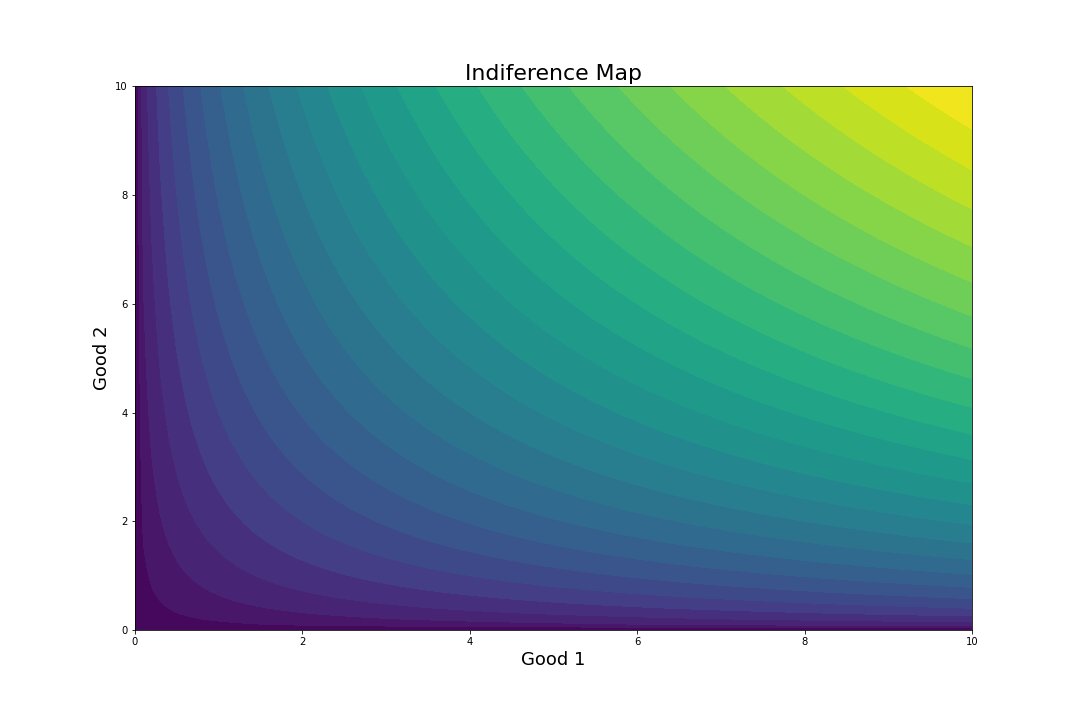

In [60]:
fig, ax = plt.subplots(figsize=(15,10))
plt.contourf(x, x, u.reshape(len(x), len(x)), 30)
plt.xlabel('Good 1', size=18)
plt.ylabel('Good 2', size=18)
plt.title('Indiference Map', size=22)

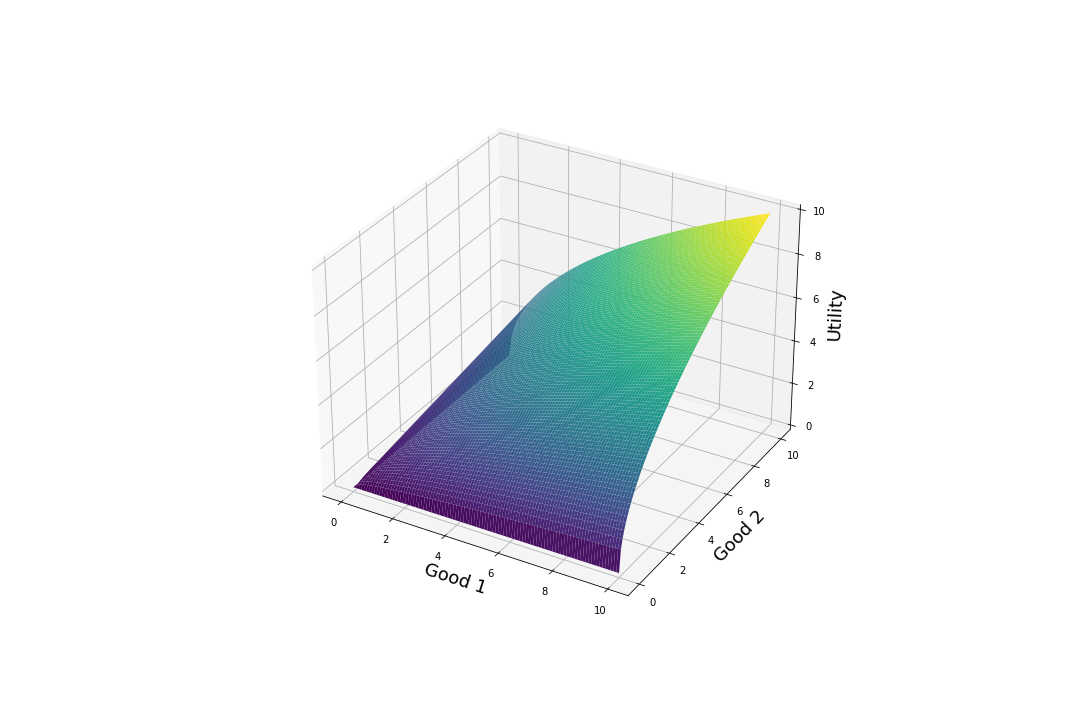

In [61]:
from mpl_toolkits.mplot3d import Axes3D
xx, yy = np.meshgrid(x, x)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xx, yy, u.reshape(len(x), len(x)), rstride=1, cstride=1, cmap='viridis')
ax.set_xlabel('Good 1', size=18)
ax.set_ylabel('Good 2', size=18)
ax.set_zlabel('Utility', size=18)
plt.show()

## Demands

Since we computed the actual demand functions $x^*_i=x^*(p, \omega_i)$ for each good $j$ for each individual $i$, in this case we can simply compute the optimal demand for each individual $i$ given her initial endowments $\omega_i$ and prices $p$.

In [6]:
def CobbDouglasDemand(p, w, alpha):
    '''
    Compute the demand vector of an individual with Cobb-Douglas Utility with parameter vector alpha,
    given her initial endowments and prices for all goods
    '''
    # Total income
    y = w.dot(p)
    ly = len(y)
    x = ((alpha / alpha.sum(axis=1, keepdims=True) * y).T / p).T
    return x

In [7]:
def ExcessDemand(p, w, alpha):
    '''
    Compute excess demand function for each good
    '''
    z = CobbDouglasDemand(p, w, alpha).sum(axis=0) - w.sum(axis=0)
    return z

In [8]:
# Let's test to make sure function is well written
alpha = np.array([[0.5, 0.5]])
w = np.array([[1, 2]])
p = np.array([[2, 1]]).T

In [9]:
CobbDouglasDemand(p, w, alpha)

array([[1., 2.]])

In [10]:
ExcessDemand(p, w, alpha)

array([0., 0.])

## This is an equilibrium, but of course in an economy with only 1 individual, $(p^*, x^*)=(p^*,\omega)$ is an equilibrium for any $p^*$.

In [62]:
alpha = np.array([[0.5, 0.5], [0.25, 0.75]])
w = np.array([[1, 2], [2, 2]])
p = np.array([[2, 1]]).T

In [63]:
CobbDouglasDemand(p, w, alpha)

array([[1.  , 2.  ],
       [0.75, 4.5 ]])

In [64]:
ExcessDemand(p, w, alpha)

array([-1.25,  2.5 ])

## Here we have excess supply for good 1 and excess demand for good 2

In [65]:
alpha = np.array([[0.5, 0.5], [0.25, 0.75], [0.5, 0.5]])
w = np.array([[1, 2], [2, 2], [1, 2]])
p = np.array([[2, 1]]).T

In [66]:
CobbDouglasDemand(p, w, alpha)

array([[1.  , 2.  ],
       [0.75, 4.5 ],
       [1.  , 2.  ]])

In [67]:
ExcessDemand(p, w, alpha)

array([-1.25,  2.5 ])

## Again we have excess supply for good 1 and excess demand for good 2

In [68]:
# Economy with 2 individuals of each type and 4 goods 2 groups of identical goods
alpha = np.array([[0.5, 0.5] * 2, [0.25, 0.75] * 2])
w = np.array([[1, 2] * 2, [2, 2] * 2] )
p = np.array([[2, 1] * 2]).T

In [69]:
CobbDouglasDemand(p, w, alpha)

array([[1.  , 2.  , 1.  , 2.  ],
       [0.75, 4.5 , 0.75, 4.5 ]])

In [70]:
ExcessDemand(p, w, alpha)

array([-1.25,  2.5 , -1.25,  2.5 ])

## We have excess supply for goods 1 & 3 and excess demand for goods 2 & 4

In [71]:
# Same economy with 6 individuals of each type
alpha = np.array([[0.5, 0.5], [0.25, 0.75]] * 6)
w = np.array([[1, 2], [2, 2]] * 6)
p = np.array([[2, 1]]).T

In [72]:
CobbDouglasDemand(p, w, alpha)

array([[1.  , 2.  ],
       [0.75, 4.5 ],
       [1.  , 2.  ],
       [0.75, 4.5 ],
       [1.  , 2.  ],
       [0.75, 4.5 ],
       [1.  , 2.  ],
       [0.75, 4.5 ],
       [1.  , 2.  ],
       [0.75, 4.5 ],
       [1.  , 2.  ],
       [0.75, 4.5 ]])

In [73]:
ExcessDemand(p, w, alpha)

array([-7.5, 15. ])

## Again we have excess supply for good 1 and excess demand for good 2

In [74]:
# Generate a random economy
np.random.seed(123456)
N = 5 # Individuals
M = 10 # Goods
alpha = np.random.uniform(0, 1, size=(N, M))
w = np.random.uniform(0, 1, size=(N, M))
p = np.random.uniform(0, 1, size=(1, M)).T

In [75]:
CobbDouglasDemand(p, w, alpha)

array([[ 0.06294882, 15.384009  ,  0.35974815,  1.78605326,  0.98713098,
         1.4619451 ,  0.32224148,  0.46684643,  0.21707141,  0.38702674],
       [ 0.1644502 ,  6.33970455,  0.15897394,  1.52212019,  1.91146183,
         1.36125119,  0.14530766,  0.3837844 ,  0.93265339,  0.08717989],
       [ 0.44055175,  3.90468844,  0.21041224,  1.22336136,  1.56694785,
         0.27756504,  0.43915708,  0.1420236 ,  0.62545458,  0.73122106],
       [ 0.6263485 ,  0.82583705,  1.63481706,  2.06095533,  1.45856805,
         2.05221523,  0.16764338,  0.30126113,  1.5545487 ,  0.26888522],
       [ 0.16962293, 10.26114459,  0.40995851,  0.89941164,  0.22872069,
         2.25932655,  0.21872618,  0.14075043,  0.77759137,  0.10540906]])

In [76]:
ExcessDemand(p, w, alpha)

array([-0.92823133, 33.45476917,  1.04394497,  5.49562486,  4.16797743,
        5.72879772, -2.22220818, -1.85816175,  1.5840073 , -0.78118152])

## Now we have excess supply for goods 1, 7, 8, and 10, and excess demand for the other

# How can we find the equilibrium price?
# We need excess demand to be equal to zero!

So, we only need to use our computer to find the zero of an equation. Luckily, this is a very well studied problem (see [this Wikipedia entry](https://en.wikipedia.org/wiki/Root-finding_algorithms)). In ``python`` we can use the ``scipy`` package.

In [77]:
from scipy.optimize import root

But before we use this to try to find an equilibrium, we need to remember a few things.

1. Equlibrium prices only determine relative prices, not absolute ones, so we need to decide on a numeraire. Various choices, e.g. chose $p_j=1$ for some good $j$. Another common option is to normalize the price vector so it has length 1.

2. Walras Law: If $M-1$ markets clear, then the $M^{th}$ market also clears.

So let's define a new excess demand function that takes these issues into account.

In [78]:
def ExcessDemand2(p, w, alpha, normalize=False):
    '''
    Compute excess demand function for all but the last good
    Price of good 1 = 1
    Prices are normalized to length of vector is equal to 1
    '''
    # Ensure p has the right shape
    p = p.reshape((np.max(p.shape), 1))
    p = np.vstack([[1], p])
    if normalize:
        p = (p / np.linalg.norm(p))
    z = CobbDouglasDemand(p, w, alpha).sum(axis=0) - w.sum(axis=0)
    return z[1:]

# Simple $2\times2$ Economy

In [79]:
alpha = np.array([[0.5, 0.5], [0.25, 0.75]])
w = np.array([[1, 2], [2, 2]])
p = np.array([[1, 0.5]]).T

Notice that the excess demand with normalized prices generates the same excess demand as with the original price vector

In [80]:
CobbDouglasDemand(p, w, alpha)

array([[1.  , 2.  ],
       [0.75, 4.5 ]])

In [81]:
ExcessDemand(p, w, alpha)

array([-1.25,  2.5 ])

In [82]:
ExcessDemand2(p[1:], w, alpha)

array([2.5])

In [83]:
sol = root(ExcessDemand2, np.array([1]), args=(w, alpha))

In [84]:
sol

    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-3.41060513e-13])
       r: array([1.12500002])
  status: 1
 success: True
       x: array([1.33333333])

In [85]:
pstar = np.vstack([[1], sol.x])
ExcessDemand(pstar, w, alpha)

array([0., 0.])

# Similar $2\times 4 $ Economy

In [86]:
# Economy with 2 individuals of each type and 4 goods 2 groups of identical goods
alpha = np.array([[0.5, 0.5] * 2, [0.25, 0.75] * 2])
w = np.array([[1, 2] * 2, [2, 2] * 2] )
p = np.array([[2, 1] * 2]).T
p = p / p[0]

In [87]:
ExcessDemand(p, w, alpha)

array([-1.25,  2.5 , -1.25,  2.5 ])

In [88]:
ExcessDemand2(p[1:], w, alpha)

array([ 2.5 , -1.25,  2.5 ])

In [89]:
sol = root(ExcessDemand2, p[1:], args=(w, alpha))

In [90]:
sol

    fjac: array([[-0.62895721,  0.65802207,  0.41402873],
       [-0.37302649, -0.72267448,  0.5818873 ],
       [-0.68210268, -0.21153853, -0.69999099]])
     fun: array([ 3.55271368e-15, -3.46389584e-14,  3.55271368e-15])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-1.01465740e-10,  1.11012285e-10,  1.00525300e-11])
       r: array([ 12.46421401,  -6.92935655,  -1.09460301,   7.56845431,
       -12.41387919,   0.23254797])
  status: 1
 success: True
       x: array([1.33333333, 1.        , 1.33333333])

In [91]:
pstar = sol.x
pstar = pstar.reshape((np.max(pstar.shape), 1))
pstar = np.vstack([[1], pstar])
ExcessDemand(pstar, w, alpha)

array([ 2.66453526e-14,  3.55271368e-15, -3.46389584e-14,  3.55271368e-15])

# $6\times 2$ Economy

Let's try with a larger economy

In [92]:
# Same economy with 6 individuals of each type
alpha = np.array([[0.5, 0.5], [0.25, 0.75]] * 6)
w = np.array([[1, 2], [2, 2]] * 6)
p = np.array([[2, 1]]).T

In [93]:
sol = root(ExcessDemand2, p[1:], args=(w, alpha))

In [94]:
sol

    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.04636308e-12])
       r: array([6.7500001])
  status: 1
 success: True
       x: array([1.33333333])

In [95]:
pstar = sol.x
pstar = pstar.reshape((np.max(pstar.shape), 1))
pstar = np.vstack([[1], pstar])
ExcessDemand(pstar, w, alpha)

array([0., 0.])

# And even larger economy $10\times5$

In [96]:
# Generate a random economy
np.random.seed(123456)
N = 5 # Individuals
M = 10 # Goods
alpha = np.random.uniform(0, 1/M, size=(N, M))
w = np.random.uniform(0, 1/M, size=(N, M))
p = np.random.uniform(0, 1/M, size=(1, M)).T

In [97]:
alpha.sum(axis=1)

array([0.49221316, 0.47207785, 0.46207345, 0.48029696, 0.47177654])

In [98]:
ExcessDemand2(np.ones((1, M-1)).T, w, alpha)

array([-0.07674737,  0.03088612,  0.18651534,  0.0374476 ,  0.01341667,
       -0.16281969, -0.06375667, -0.01270213, -0.01086539])

In [99]:
sol = root(ExcessDemand2, np.ones((1, M-1)).T, args=(w, alpha))

In [100]:
sol

    fjac: array([[-0.97464726,  0.04059005,  0.08124723,  0.04631381,  0.05691774,
         0.12506279,  0.10236769,  0.07151283,  0.07208003],
       [ 0.03606727, -0.9383307 ,  0.12858517,  0.0672332 ,  0.12461059,
         0.16820018,  0.13556554,  0.17119197,  0.07534189],
       [ 0.05447312,  0.07375412, -0.81455107,  0.12017277,  0.15913621,
         0.31160695,  0.32369185,  0.17513512,  0.23619085],
       [ 0.03593944,  0.06136329,  0.10218258, -0.92937828,  0.10782306,
         0.17224962,  0.2146313 ,  0.16276907,  0.0830754 ],
       [ 0.02531927, -0.00238874,  0.06856393,  0.02847763, -0.92539275,
         0.22470325,  0.20311207,  0.1395213 ,  0.16210258],
       [-0.06792698, -0.08794553, -0.13177869, -0.06141629, -0.08241399,
        -0.87127438,  0.32258962,  0.21891082,  0.22049218],
       [-0.06080575, -0.06604033, -0.18310706, -0.12400818, -0.07871698,
        -0.04434082, -0.7964004 ,  0.40682752,  0.36757368],
       [-0.05303592, -0.14892238, -0.09858614, -0.14

In [101]:
pstar = sol.x
pstar = pstar.reshape((np.max(pstar.shape), 1))
pstar = np.vstack([[1], pstar])
ExcessDemand(pstar, w, alpha)

array([ 4.47104298e-11,  2.43798037e-10, -5.31184957e-10,  2.49777976e-12,
        6.04061079e-10, -1.99401939e-10, -1.21951560e-10, -4.86894192e-10,
        3.44903162e-10,  9.40439393e-12])

# Let's now replicate this with CES utility

The CES utility function is given by

$$
u_i(x_i)=u_i(x_{i1},\ldots,x_{iM})=\left(\sum_{j=1}^M a_{ij}^{\frac{1}{\sigma}}x_{ij}^{\frac{\sigma-1}{\sigma}}\right)^{\frac{\sigma}{\sigma-1}} = X_i^{\frac{\sigma}{\sigma-1}}
$$
where 

$$
X_i=\sum_{j=1}^M a_{ij}^{\frac{1}{\sigma}}x_{ij}^{\frac{\sigma-1}{\sigma}}.
$$

So, the marginal utility given by

$$
\frac{\partial u_i}{\partial x_{ij}}=\frac{\sigma}{\sigma-1} X_i^{\frac{\sigma}{\sigma-1}-1}
\frac{\sigma-1}{\sigma}a_{ij}^{\frac{1}{\sigma}}x_{ij}^{\frac{\sigma-1}{\sigma}-1}
$$

which is equivalent to

$$
\frac{\partial u_i}{\partial x_{ij}}= \frac{u_i}{X_i}
\frac{a_{ij}^{\frac{1}{\sigma}}x_{ij}^{\frac{\sigma-1}{\sigma}}}{x_{ij}}
$$

## Exercise
1. Write the functions to compute the demand and excess demand functions for an economy where individuals have CES preferences
2. Use the previous code to compute the equilibrium price vector.